This note book realizes adaptive fuzzy neural network with Tensorflow

The architecture of AFNN as folow:
![](https://www.researchgate.net/profile/Ahmed_Hafaifa/publication/305519718/figure/fig4/AS:391662376374286@1470390995677/Adaptive-fuzzy-neural-network-with-inference-system.png)

where:

- layer 1: **Fuzzification layer**: $A_{ij} \rightarrow \mu_{ij}(x_i=A_{ij})$
- layer 2: **Rule operation layer**: $\displaystyle \Pi_r = \prod_{i=1,\ x_i=A_{ij}}^{m}\mu_{ij}(x_i=A_{ij})$
- layer 3: **Normalization layer**: $\displaystyle \overline{w}_r = \frac{w_r}{\sum_{r'}w_{r'}}$
- layer 4: **Consequent layer**: $c_r = \overline{w}_rf_r$
- layer 5: **Aggregation layer**: $\hat{y}=\sum_{r}\overline{w}_rf_r$
- All $f_r$ are found by minimum objective function based on true values ($y_k$) and predicted values ($\hat{y}_k$)
- Finally rules can be expressed as:
$$
\mathbf{If\ } x_1 = A_{11} \mathbf{\ and\ } x_1 = A_{21} \mathbf{\ and...\ then\ } y=f_1 \text{ and so on ...}
$$

#### Gaussian membership function
$$mf_{\mu, \sigma}(x)=\exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)$$


In [1]:
def gaussmf(x, mean, sigma):
    return np.exp(-((x - mean)**2.) / (2 * sigma**2.))

## ANFIS class implementation

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time


class ANFIS:

    def __init__(self, n_inputs, n_rules, learning_rate=1e-2):
        """
        Initialization method
        :param n_inputs: number of input variables, (dimmension of input)
        :param n_rules: number of rules (membership functions) per variables
        :param learning_rate: learning rate
        """

        self.n = n_inputs  # input dimmension
        self.m = n_rules   # membership functions per dimmension
                           # number of possible rules = n * m
        
        # node for input
        self.inputs = tf.placeholder(tf.float32, shape=(None, n_inputs), name='input')
        # node for desired output
        self.targets = tf.placeholder(tf.float32, shape=None, name='target')
        
        # Initialise means (of gaussian membership functions)
        mu = tf.get_variable(
            name="mu", 
            shape=[n_rules * n_inputs],
            initializer=tf.random_normal_initializer(0, 1)
        )
        
        # Initialise sigmas (Standard deviations of Gaussian MFS)
        sigma = tf.get_variable(
            name="sigma", 
            shape=[n_rules * n_inputs],
            initializer=tf.random_normal_initializer(0, 1)
        ) 
        
        # Sequent centers (outputs of rules)
        y = tf.get_variable(
            name="y",
            shape=[1, n_rules],
            initializer=tf.random_normal_initializer(0, 1)
        )

        # Parameters to update: mu + sigma + y
        self.params = tf.trainable_variables() 
        
        # layer 1: Fuzzification layer
        numerator = tf.square(
            tf.subtract(
                x=tf.tile(
                    self.inputs, 
                    (1, n_rules)
                ), 
                y=mu
            )
        )
        denominator = 2*tf.square(sigma)
        layer1 = tf.exp(-numerator/denominator)
        
        # layer 2: Rule operation layer
        self.rul = tf.reduce_prod(
            input_tensor=tf.reshape(
                tensor=layer1, 
                shape=(-1, n_rules, n_inputs)
            ), 
            axis=2
        )

        # Fuzzy base expansion function:
        # denominator of layer 3 - normalization layer
        den = tf.clip_by_value(tf.reduce_sum(self.rul, axis=1), 1e-12, 1e12)
        
        # layer 4 - consequent layer
        layer4 = tf.multiply(self.rul, y)
        num = tf.reduce_sum(layer4, axis=1)
        
        # layer 5 - output
        self.out = tf.divide(num, den)

        # Loss - objective function
        self.loss = tf.losses.huber_loss(self.targets, self.out)  # Loss function computation
        # Other loss functions for regression, uncomment to try them:
        # loss = tf.sqrt(tf.losses.mean_squared_error(target, out))
        # loss = tf.losses.absolute_difference(target, out)
        
        self.optimize = tf.train.AdamOptimizer(
            learning_rate=learning_rate
        ).minimize(self.loss)  # Optimization step
        
        # Other optimizers, uncomment to try them:
        # self.optimize = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(self.loss)
        # self.optimize = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(self.loss)
        
        self.init_variables = tf.global_variables_initializer()  # Variable initializer

    def infer(self, sess, x, targets=None):
        """
        Inference process
        """
        if targets is None:
            # if there is no target, return predicted value
            return sess.run(self.out, feed_dict={self.inputs: x})
        else:
            # else targets are defined, return predicted value and loss value
            return sess.run(
                [self.out, self.loss], 
                feed_dict={self.inputs: x, self.targets: targets}
            )

    def train(self, sess, x, targets):
        """
        Train model with input x and true value y
        Return loss and predicted values
        """
        yp, l, _ = sess.run(
            [self.out, self.loss, self.optimize], 
            feed_dict={self.inputs: x, self.targets: targets}
        )
        return l, yp

    def plotmfs(self, sess):
        """
        Plot membership function
        """
        # Get means
        mus = sess.run(self.params[0])
        mus = np.reshape(mus, (self.m, self.n))
        
        # Get sigmas
        sigmas = sess.run(self.params[1])
        sigmas = np.reshape(sigmas, (self.m, self.n))
        
        # Get value of rule
        y = sess.run(self.params[2])
        
        xn = np.linspace(-5, 5, 1000)
        
        for r in range(self.m):
            # for 
            if r % 4 == 0:
                plt.figure(figsize=(11, 6), dpi=80)
            # plt.subplot(2, 2, (r % 4) + 1)
            ax = plt.subplot(2, 2, (r % 4) + 1)
            ax.set_title("Rule %d, sequent center: %f" % ((r + 1), y[0, r]))
            # ax.set_title("Rule %d" % (r + 1))
            for i in range(self.n):
                plt.plot(xn, gaussmf(x=xn, mean=mus[r, i], sigma=sigmas[r, i]))
                # plt.plot(xn, np.exp(-0.5 * ((xn - mus[r, i]) ** 2) / (sigmas[r, i] ** 2)))

/home/hung/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Example run

In [3]:
# Mackey-Glass series computation
def mackey(n_iters):
    x = np.zeros((n_iters,))
    x[0:30] = 0.23 * np.ones((30,))
    t_s = 30
    for i in range(30, n_iters - 1):
        a = x[i]
        b = x[i - t_s]
        y = ((0.2 * b) / (1 + b ** 10)) + 0.9 * a
        x[i + 1] = y
    return x


# Generate dataset
D = 2  # number of regressors
T = 1  # delay
N = 2000  # Number of points to generate
mg_series = mackey(N)[499:]  # Use last 1500 points
data = np.zeros((N - 500 - T - (D - 1) * T, D))
lbls = np.zeros((N - 500 - T - (D - 1) * T,))

for t in range((D - 1) * T, N - 500 - T):
    data[t - (D - 1) * T, :] = [mg_series[t - T], mg_series[t]]
    ## [mg_series[t - 3 * T], mg_series[t - 2 * T], mg_series[t - T], mg_series[t]]
    lbls[t - (D - 1) * T] = mg_series[t + T]
trnData = data[:lbls.size - round(lbls.size * 0.3), :]
trnLbls = lbls[:lbls.size - round(lbls.size * 0.3)]
chkData = data[lbls.size - round(lbls.size * 0.3):, :]
chkLbls = lbls[lbls.size - round(lbls.size * 0.3):]

# print(trnData.shape, trnLbls.shape)

Train cost after epoch 0: 0.108338
Train cost after epoch 10: 0.019356
Train cost after epoch 20: 0.011108
Train cost after epoch 30: 0.006717
Train cost after epoch 40: 0.002542
Train cost after epoch 50: 0.002032
Train cost after epoch 60: 0.001552
Train cost after epoch 70: 0.001318
Train cost after epoch 80: 0.001249
Train cost after epoch 90: 0.001203
Elapsed time: 0.667924
Validation loss: 0.001253


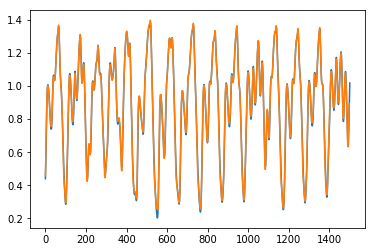

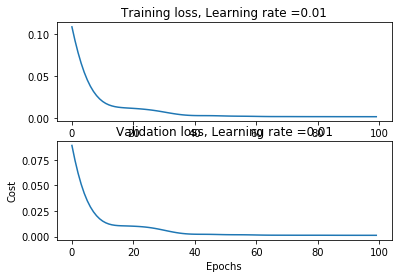

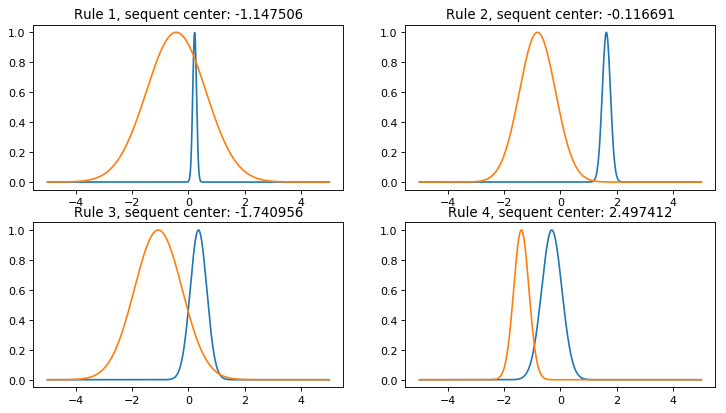

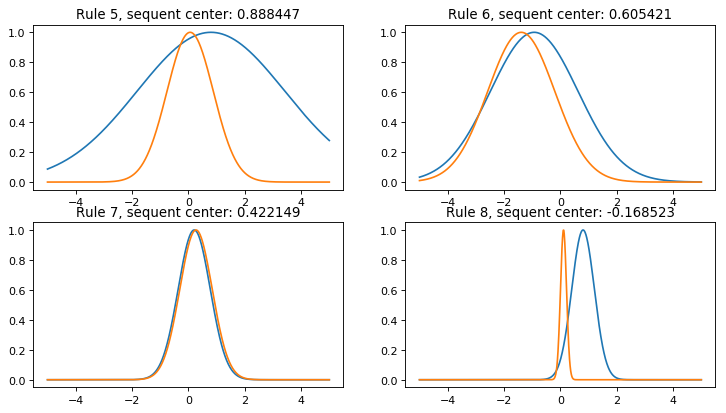

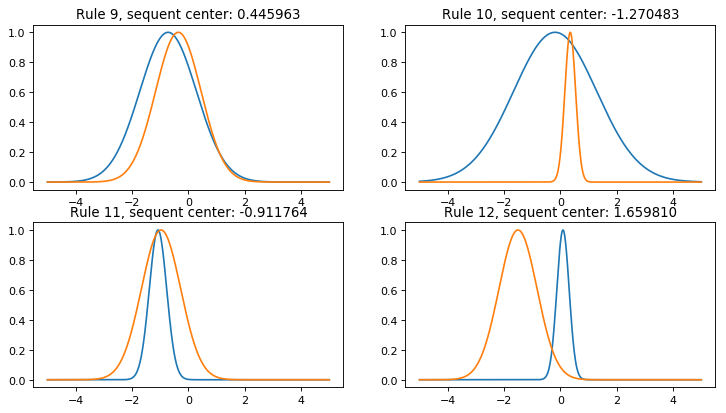

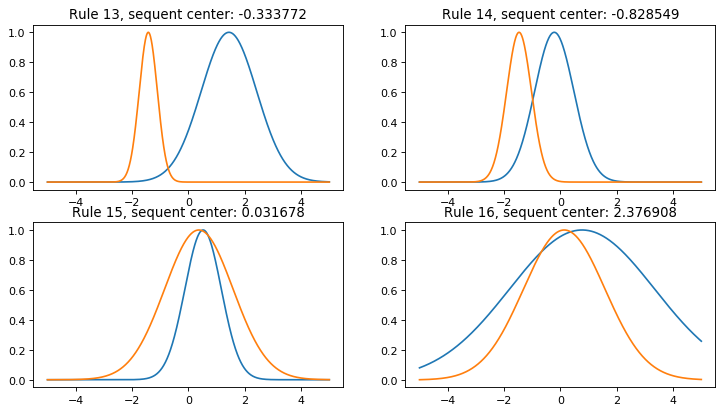

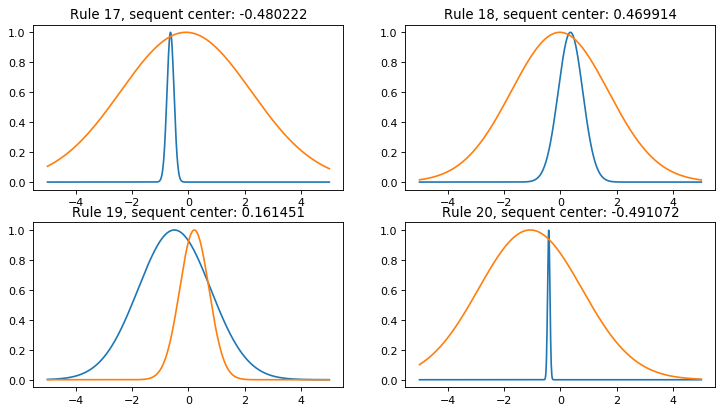

In [4]:
# ANFIS params and Tensorflow graph initialization
m = 20  # number of rules
alpha = 0.01  # learning rate

fis = ANFIS(n_inputs=D, n_rules=m, learning_rate=alpha)

# Training
num_epochs = 100

# Initialize session to make computations on the Tensorflow graph
with tf.Session() as sess:
    # Initialize model parameters
    sess.run(fis.init_variables)
    trn_costs = []
    val_costs = []
    time_start = time.time()
    for epoch in range(num_epochs):
        #  Run an update step
        trn_loss, trn_pred = fis.train(sess, trnData, trnLbls)
        # Evaluate on validation set
        val_pred, val_loss = fis.infer(sess, chkData, chkLbls)
        if epoch % 10 == 0:
            print("Train cost after epoch %i: %f" % (epoch, trn_loss))
        if epoch == num_epochs - 1:
            time_end = time.time()
            print("Elapsed time: %f" % (time_end - time_start))
            print("Validation loss: %f" % val_loss)
            # Plot real vs. predicted
            pred = np.vstack((np.expand_dims(trn_pred, 1), np.expand_dims(val_pred, 1)))
            plt.figure(1)
            plt.plot(mg_series)
            plt.plot(pred)
        trn_costs.append(trn_loss)
        val_costs.append(val_loss)
    # Plot the cost over epochs
    plt.figure(2)
    plt.subplot(2, 1, 1)
    plt.plot(np.squeeze(trn_costs))
    plt.title("Training loss, Learning rate =" + str(alpha))
    plt.subplot(2, 1, 2)
    plt.plot(np.squeeze(val_costs))
    plt.title("Validation loss, Learning rate =" + str(alpha))
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    # Plot resulting membership functions
    fis.plotmfs(sess)
    plt.show()